In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 1. Load data
df_pca = pd.read_csv("/content/drive/MyDrive/tft/data/new/df_pca_n_ts.csv", parse_dates=["timestamp"])
df_trends = pd.read_csv("/content/drive/MyDrive/tft/data/google_trend/btc_trends.csv", parse_dates=["timestamp"])

# 2. Fill missing trend data with zeros
trend_cols = [c for c in df_trends.columns if c != "timestamp"]
df_trends[trend_cols] = df_trends[trend_cols].fillna(0)

# 3. Set timestamp indices
df_trends = df_trends.set_index("timestamp")
df_pca = df_pca.set_index("timestamp")

# 4. Upsample BTC trends to 5-min intervals + linear interpolation
df_trends_5m = (
    df_trends
    .resample("5T")  # 5‑minute intervals
    .interpolate(method="time")  # linear time-based interpolation :contentReference[oaicite:1]{index=1}
)

# Optional: smooth with 3‑point rolling mean (≈15 minutes)
df_trends_5m = df_trends_5m.rolling(window=3, min_periods=1, center=True).mean()  # :contentReference[oaicite:2]{index=2}

# 5. Merge into PCA DataFrame
df_merged = df_pca.join(df_trends_5m, how="left")

# 6. Fill any remaining NaNs in trend columns (e.g., before/after range) with zeros
df_merged[trend_cols] = df_merged[trend_cols].fillna(0)

# 7. Reset index and save
df_merged.reset_index().to_csv("/content/drive/MyDrive/tft/data/new/df_with_trends_5m.csv", index=False)

print("✅ Saved df_with_trends_5m.csv with shape:", df_merged.shape)


/tmp/ipython-input-2-254195607.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("5T")  # 5‑minute intervals


✅ Saved df_with_trends_5m.csv with shape: (210485, 22)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import ccf

# 2. Load merged data
df = pd.read_csv("/content/drive/MyDrive/tft/data/new/df_with_trends_5m.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [16]:
# 3. Resample to hourly for alignment in analysis
df_hr = df.resample("1H").mean()

/tmp/ipython-input-16-2967945211.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hr = df.resample("1H").mean()


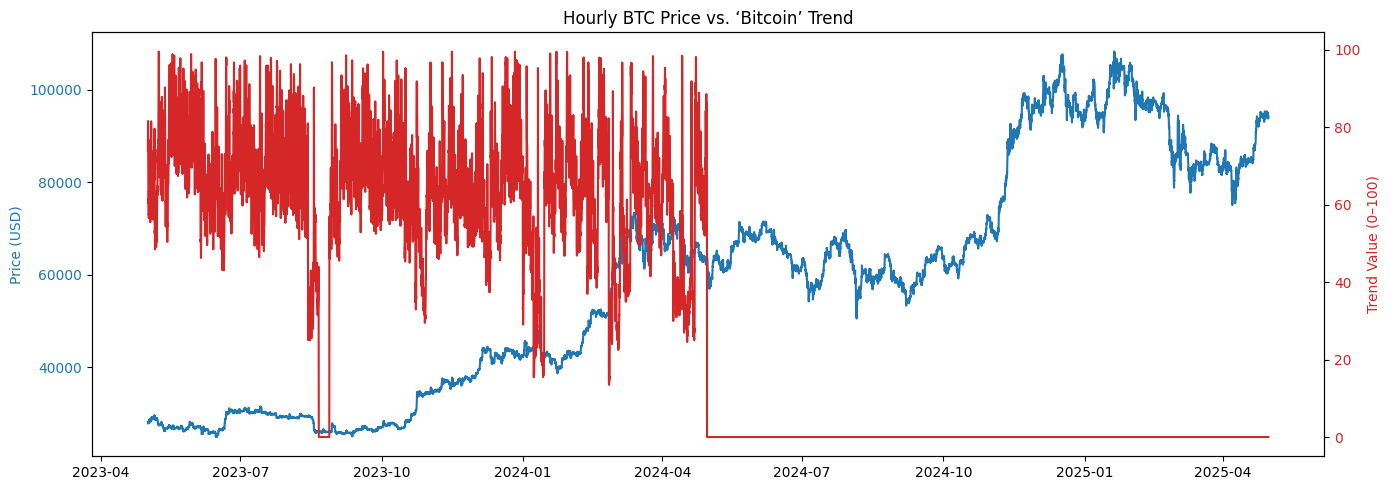

In [17]:
# 3a. Dual-Axis Plot
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_hr.index, df_hr["close"], color="tab:blue", label="BTC Close Price")
ax1.set_ylabel("Price (USD)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()  # create secondary y-axis :contentReference[oaicite:4]{index=4}
ax2.plot(df_hr.index, df_hr["Bitcoin"], color="tab:red", label="Bitcoin Trend")
ax2.set_ylabel("Trend Value (0–100)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Hourly BTC Price vs. ‘Bitcoin’ Trend")
fig.tight_layout()
plt.show()

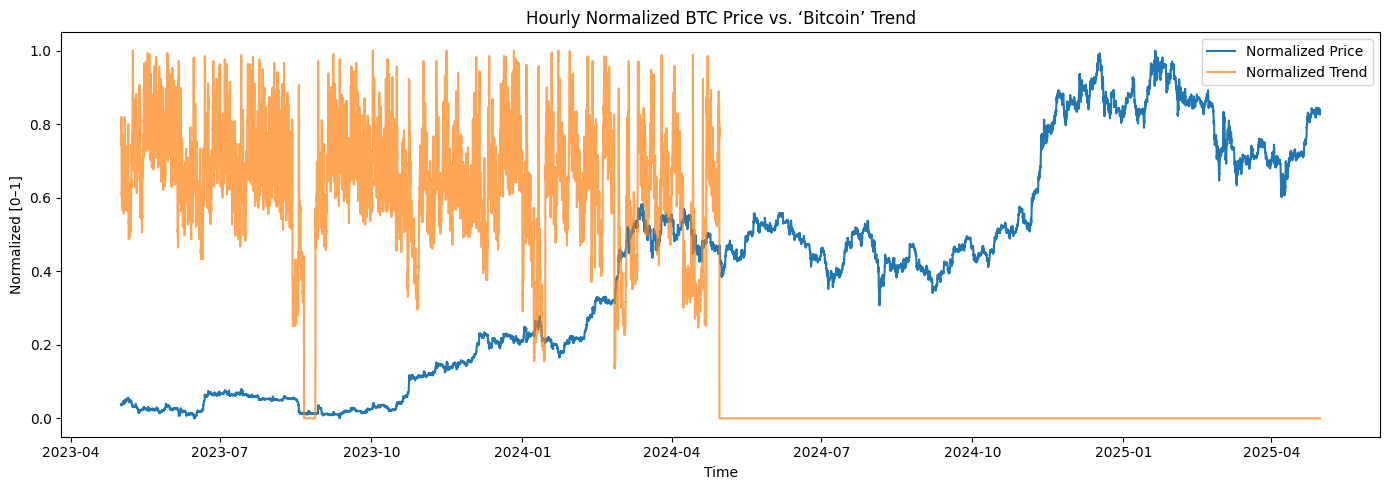

In [18]:
# 3b. Normalized Overlay (optional)
#    Rescale both series to [0,1] to compare relative movements on one axis. :contentReference[oaicite:5]{index=5}
cols = ["close", "Bitcoin"]
df_norm = (df_hr[cols] - df_hr[cols].min()) / (df_hr[cols].max() - df_hr[cols].min())

plt.figure(figsize=(14,5))
plt.plot(df_norm.index, df_norm["close"], label="Normalized Price")
plt.plot(df_norm.index, df_norm["Bitcoin"], label="Normalized Trend", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Normalized [0–1]")
plt.title("Hourly Normalized BTC Price vs. ‘Bitcoin’ Trend")
plt.legend()
plt.tight_layout()
plt.show()

Plotting from 2023-05-01 through 2023-05-16, 343 hours of data.


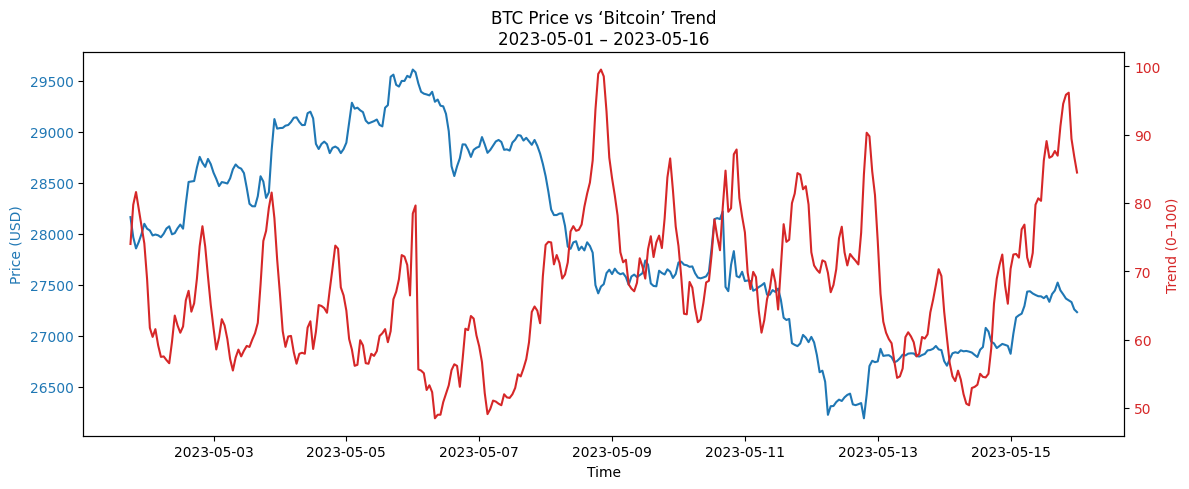

In [26]:
# 2. Define your one-month window
#    Option A: last full month in your data
start = df_hr.index.min().floor('D')
end = (start + pd.Timedelta(days=15))

#    Option B: any specific calendar month, e.g. March 2023:
#    start = pd.Timestamp("2023-03-01")
#    end   = pd.Timestamp("2023-04-01") - pd.Timedelta(seconds=1)

df_month = df_hr.loc[start:end]

print(f"Plotting from {start.date()} through {end.date()}, {len(df_month)} hours of data.")

# 3a. Dual-Axis Plot for the month
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df_month.index, df_month["close"], color="tab:blue", label="BTC Close")
ax1.set_ylabel("Price (USD)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(df_month.index, df_month["Bitcoin"], color="tab:red", label="Bitcoin Trend")
ax2.set_ylabel("Trend (0–100)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"BTC Price vs ‘Bitcoin’ Trend\n{start.date()} – {end.date()}")
fig.tight_layout()
plt.show()

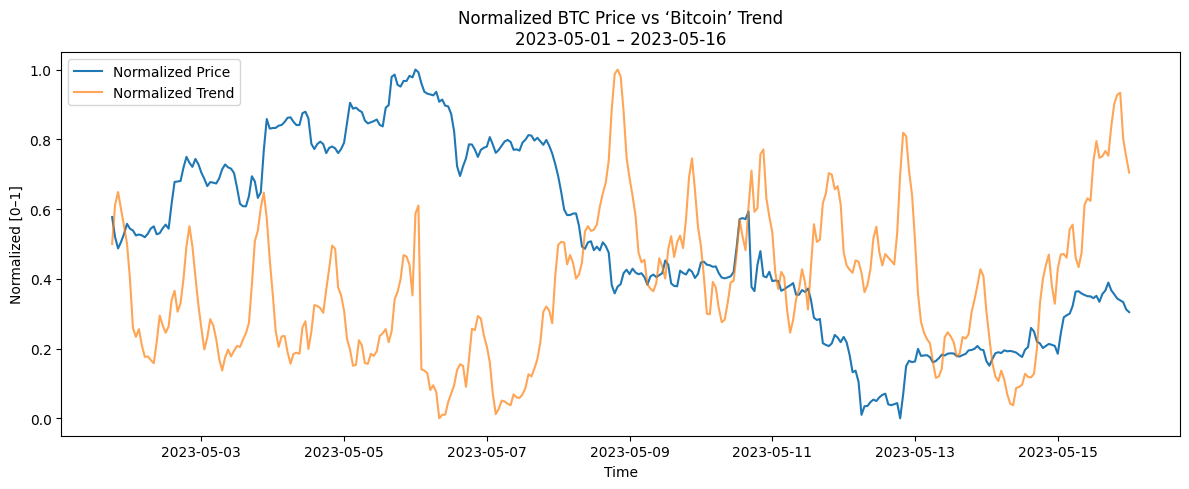

In [27]:
# 3b. Normalized Overlay for the month
cols = ["close", "Bitcoin"]
df_norm = (df_month[cols] - df_month[cols].min()) / (df_month[cols].max() - df_month[cols].min())

plt.figure(figsize=(12,5))
plt.plot(df_norm.index, df_norm["close"], label="Normalized Price")
plt.plot(df_norm.index, df_norm["Bitcoin"], label="Normalized Trend", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Normalized [0–1]")
plt.title(f"Normalized BTC Price vs ‘Bitcoin’ Trend\n{start.date()} – {end.date()}")
plt.legend()
plt.tight_layout()
plt.show()

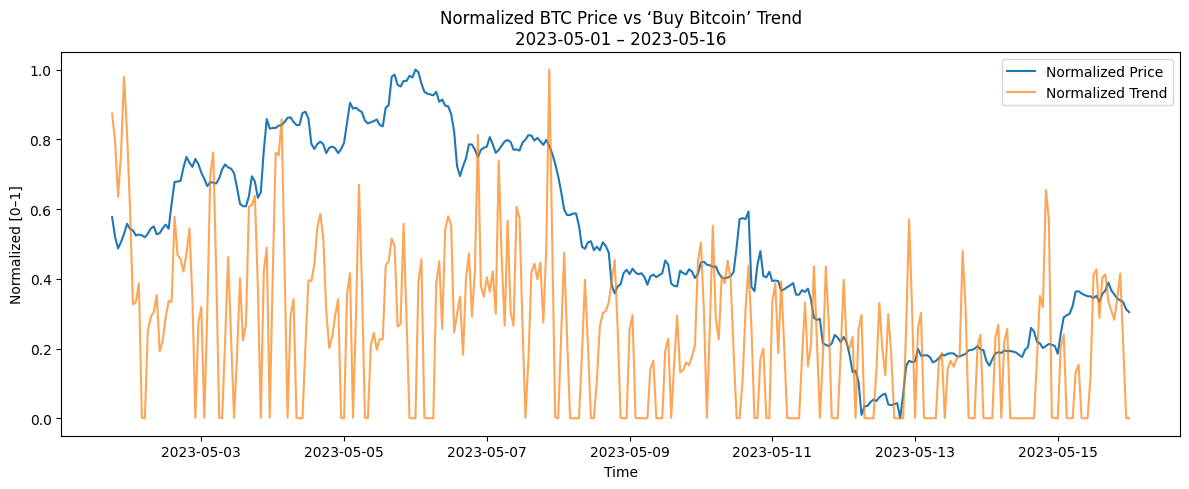

In [28]:
# 3b. Normalized Overlay for the month
cols = ["close", "Buy Bitcoin"]
df_norm = (df_month[cols] - df_month[cols].min()) / (df_month[cols].max() - df_month[cols].min())

plt.figure(figsize=(12,5))
plt.plot(df_norm.index, df_norm["close"], label="Normalized Price")
plt.plot(df_norm.index, df_norm["Buy Bitcoin"], label="Normalized Trend", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Normalized [0–1]")
plt.title(f"Normalized BTC Price vs ‘Buy Bitcoin’ Trend\n{start.date()} – {end.date()}")
plt.legend()
plt.tight_layout()
plt.show()

Pearson correlations:
  • Bitcoin: r=-0.753, p-value=0.000e+00
  • Bitcoin price: r=-0.768, p-value=0.000e+00
  • Bitcoin dip: r=-0.052, p-value=8.759e-12
  • Buy Bitcoin: r=-0.500, p-value=0.000e+00


Text(0.5, 1.02, 'Pairplot: Price vs Trends')

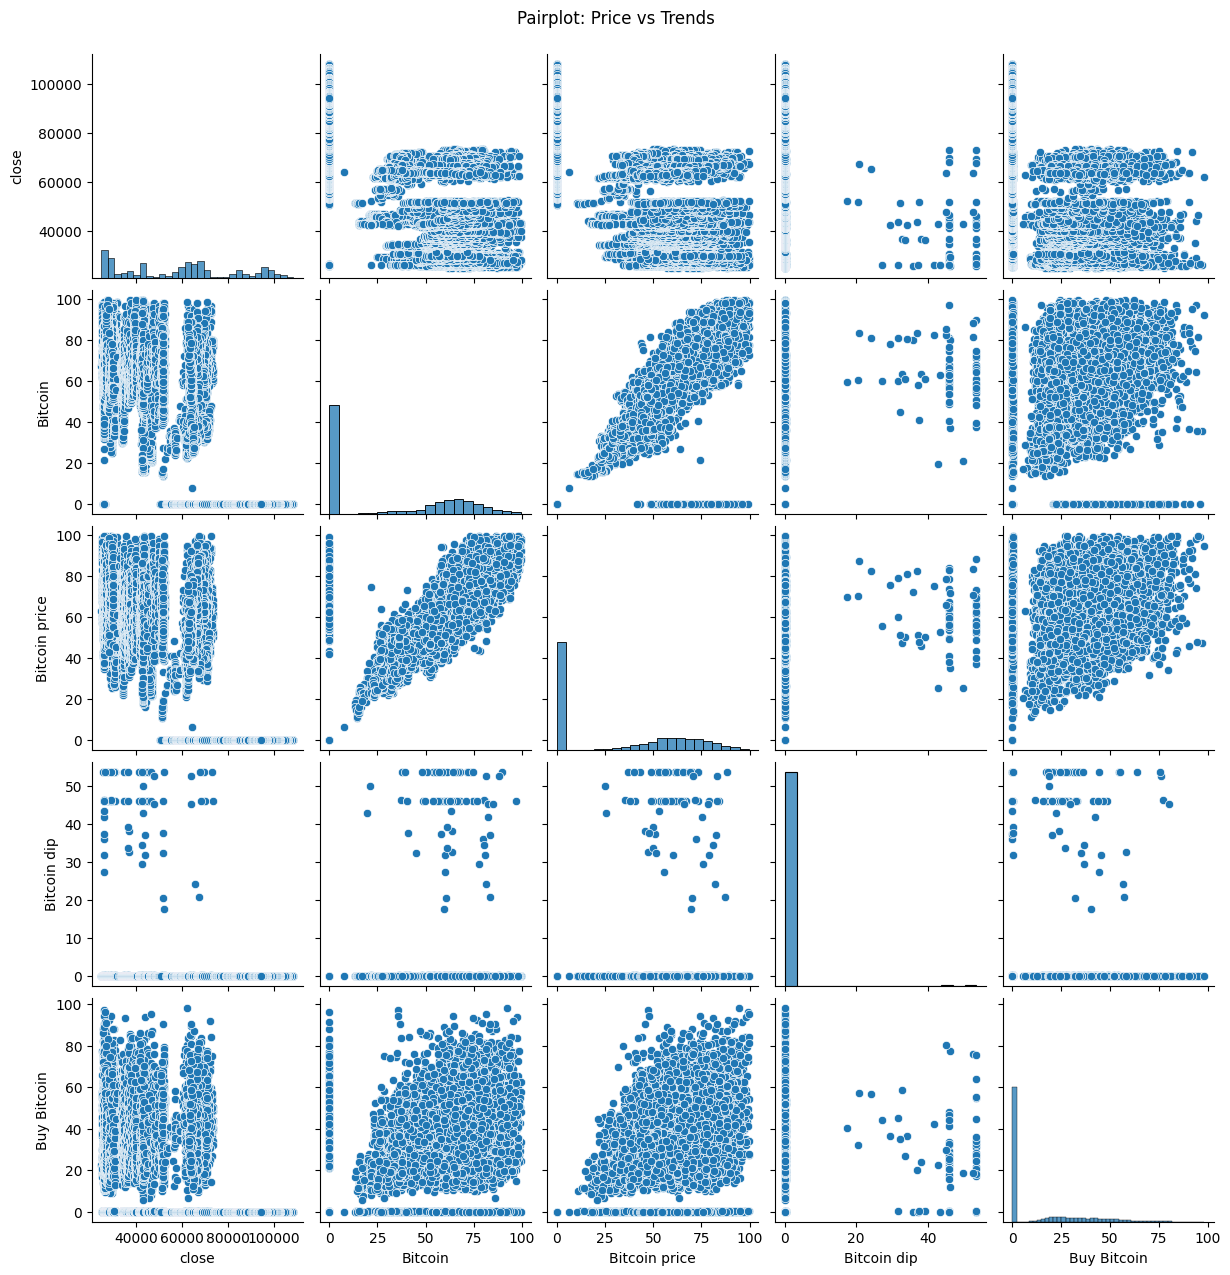

In [19]:
# 5. Scatter + Pearson correlation
trend_cols = ['Bitcoin','Bitcoin price','Bitcoin dip','Buy Bitcoin']
print("Pearson correlations:")
for col in trend_cols:
    corr, pval = pearsonr(df_hr['close'], df_hr[col])
    print(f"  • {col}: r={corr:.3f}, p-value={pval:.3e}")

# 6. Pairplot and correlation matrix heatmap
sns.pairplot(df_hr[['close'] + trend_cols].dropna())
plt.suptitle("Pairplot: Price vs Trends", y=1.02)

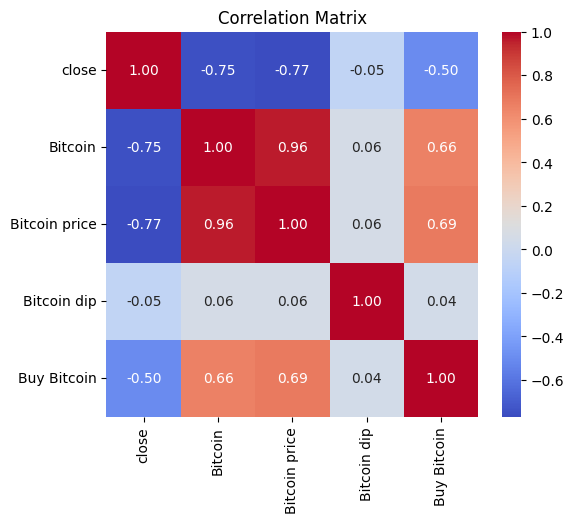

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(df_hr[['close'] + trend_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

/tmp/ipython-input-21-967189267.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_hr['close'].fillna(method='ffill')
/tmp/ipython-input-21-967189267.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cc_values = [pearsonr(x.shift(lag)[lags], y[lags])[0] for lag in lags]


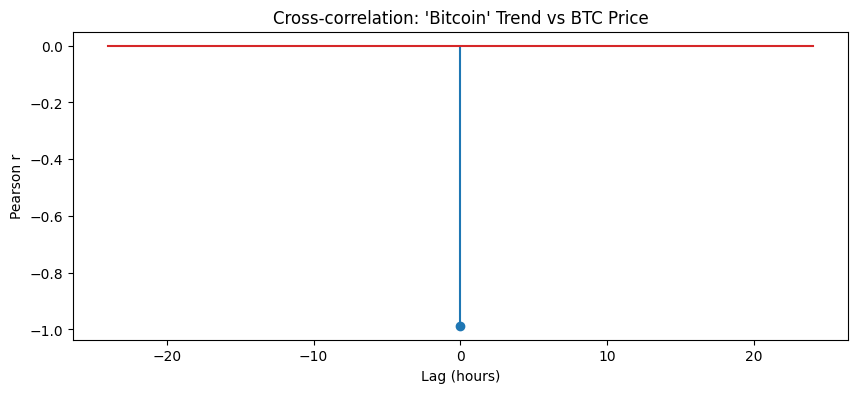

In [21]:
# 7. Cross-correlation (CCF) for lag analysis
x = df_hr['Bitcoin'].fillna(0)
y = df_hr['close'].fillna(method='ffill')
lags = range(-24, 25)  # +/- 24 hours
cc_values = [pearsonr(x.shift(lag)[lags], y[lags])[0] for lag in lags]

plt.figure(figsize=(10,4))
plt.stem(lags, cc_values)  # removed use_line_collection
plt.xlabel("Lag (hours)")
plt.ylabel("Pearson r")
plt.title("Cross-correlation: 'Bitcoin' Trend vs BTC Price")
plt.show()